# Gibbs Sampling for Normal distribution with unknown mean and variance and semi-conjugate priors

#### **Likelihood:**
$p(x|\mu, \sigma^2) = \mathcal{N}(x|\mu, \sigma^2)$ \\
$p(\mathbf{X} | \mu, \sigma^2) = \prod_{n=1}^N \mathcal{N}(x_n|\mu, \sigma^2)$

#### **Prior over $\mu$:**
$p(\mu|\mu_0, \sigma_0^2) = \mathcal{N}(\mu|\mu_0, \sigma_0^2)$

#### **Prior over $\sigma^2$:**
$p(\sigma^2|\alpha, \beta) = IG(\sigma^2 | \alpha, \beta)$

#### **Conditional Posterior over $\mu$:**
$p(\mu | \mathbf{X}, \sigma^2) = \mathcal{N}(\mu | \mu_N, \sigma_N^2)$ \\
where, $\frac{1}{\sigma_N^2} = \frac{1}{\sigma_0^2} + \frac{N}{\sigma^2}$ and $\mu_N = \frac{\sigma^2}{N\sigma_0^2 + \sigma^2}\mu_0 + \frac{N\sigma_0^2}{N\sigma_0^2 + \sigma^2}\bar{x}$

#### **Conditional Posterior over $\sigma^2$:**
$p(\sigma^2|\mathbf{X}, \mu) = IG\left(\sigma^2 \middle| \alpha + \frac{N}{2}, \beta + \frac{\sum_{n=1}^{N} (x_n - \mu)^2}{2}\right)$

In [ ]:
# !pip install gif
import numpy as np
import random
import gif
from scipy.stats import invgamma
import matplotlib.pyplot as plt
plt.style.use('seaborn') # pretty matplotlib plots

### Generating the synthetic data:

$\mu$ and $\sigma^2$ are drawn from their prior distributions and a corresponding $x$ is generated from the likelihood model.

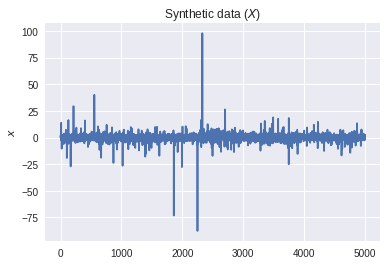

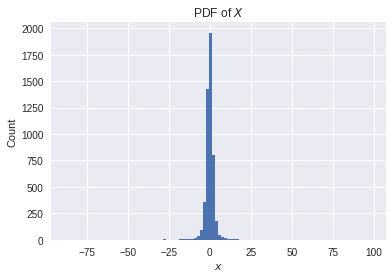

In [2]:
# Choose the values of hyperparameters of the priors
mu_0 = 0
sigma2_0 = 1
alpha = 1
beta = 1

N = 5000 # no. of samples
X = [] # synthetic X data

# Sample some mu from the prior
mu_array = np.random.normal(mu_0, np.sqrt(sigma2_0), N)

# Sample some sigma from the prior
sigma2_array = beta*invgamma.rvs(alpha,size=N)

for i in range(N):
  X.append(np.random.normal(mu_array[i], np.sqrt(sigma2_array[i])))

plt.plot(X)
plt.title("Synthetic data ($X$)")
plt.ylabel("$x$")
plt.show()

plt.hist(X, bins=100)
plt.title("PDF of $X$")
plt.xlabel("$x$")
plt.ylabel("Count")
plt.show()

In [3]:
# This function borrowed from https://github.com/mr-easy/Gibbs-Sampling-Visualized
@gif.frame
def plot_samples(samples, num_samples, tmp_points, num_tmp, xlims, ylims, title="Gibbs Sampling"):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.gca()
    
    # Plot sampled points
    ax.scatter(samples[:num_samples, 0], samples[:num_samples, 1], c='b', s=10, label="Sampled Points")
    
    # Plot samples from conditional distribution
    ax.scatter(tmp_points[:num_tmp, 0], tmp_points[:num_tmp, 1], c='r', alpha=0.4, s=5, label="Temporary Points")
    
    # Keeping the axes scales same for good GIFs
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    
    # Plot lines
    if(num_tmp > 0):
        ax.plot([samples[num_samples-1, 0], tmp_points[num_tmp-1, 0]], [samples[num_samples-1, 1], tmp_points[num_tmp-1, 1]], c='k', alpha=0.25)
    
    ax.legend(loc='upper left')
    ax.set_title(title)

In [4]:
def gibbs_sampler(num_samples, create_gif=True, xlims=(-0.20, 0.20), ylims=(6,10)):

    frames = []  # for GIF

    sample_mean = np.mean(X)
    mu = np.zeros((num_samples+1))
    sigma2 = np.zeros((num_samples+1))
    # Initialize sigma^2^(0) randomly
    sigma2[0] = random.random()

    point = np.zeros((2))
    point[1] = sigma2[0]
    samples = np.empty([num_samples+1, 2])  # sampled points
    samples[0] = point
    tmp_points = np.empty([num_samples+1, 2]) # inbetween points

    for t in range(1, num_samples+1):

        # Sample mu[t] using sigma^2[t-1]
        sigma2_N = 1 / ( 1 / sigma2_0 + N / sigma2[t-1])
        mu_N = (sigma2[t-1] * mu_0 + N*sigma2_0 * sample_mean) / (N*sigma2_0 + sigma2[t-1])
        mu[t] = np.random.normal( mu_N, np.sqrt(sigma2_N))

        point[0] = mu[t]
        point[1] = sigma2[t-1]
        tmp_points[t] = point
        if(create_gif):
          frames.append(plot_samples(samples, t, tmp_points, t, xlims, ylims, title="Num Samples: " + str(t)))
        
        # Sample sigma2[t] using mu[t]
        alpha_N = alpha + N/2
        beta_N = beta + np.sum( (X - mu[t])**2 ) / 2
        sigma2[t] = beta_N*invgamma.rvs(alpha_N,size=1)

        point[0] = mu[t]
        point[1] = sigma2[t]
        samples[t] = point
        if(create_gif):
          frames.append(plot_samples(samples, t+1, tmp_points, t, xlims, ylims, title="Num Samples: " + str(t+1)))
          
    return samples[1:], tmp_points, frames

### Histogram plots for sampled $\mu$ and $\sigma^2$:

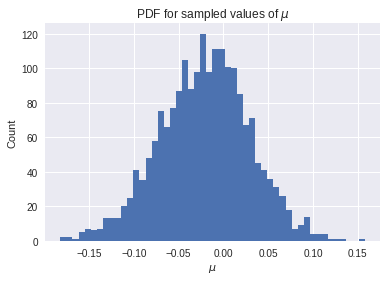

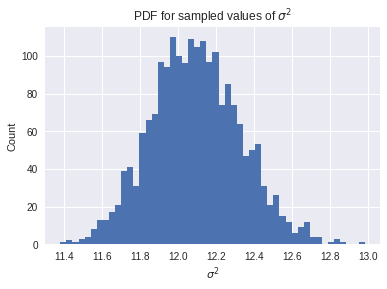

In [5]:
num_samples = 2000
samples, _, _ = gibbs_sampler(num_samples, create_gif=False)

mu = samples[1:, 0]
sigma2 = samples[1:, 1]

plt.hist(mu, bins=50)
plt.title("PDF for sampled values of $\mu$")
plt.xlabel("$\mu$")
plt.ylabel("Count")
plt.show()

plt.hist(sigma2, bins=50)
plt.title("PDF for sampled values of $\sigma^2$")
plt.xlabel("$\sigma^2$")
plt.ylabel("Count")
plt.show()

### Scatter plot for the sampled $\{(\mu, \sigma^2)\}_{s=1}^{2000}$:

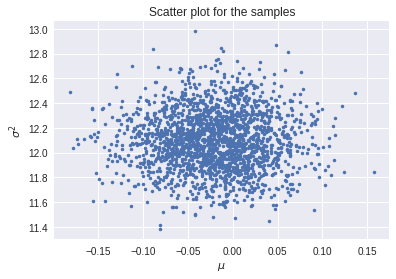

In [6]:
plt.plot(mu, sigma2, '.')
plt.title("Scatter plot for the samples")
plt.xlabel("$\mu$")
plt.ylabel("$\sigma^2$")

plt.show()

### Interactive demo for the Gibbs sampler:

Note: The veritcal lines in the GIF show that the next point is drawn from a Gaussian distribution centred at the previous (temporary) point.

In [7]:
num_samples = 500
# Put a valid value of xlims and ylims from the previous scatter plot
_, _, frames = gibbs_sampler(num_samples, xlims=(-0.20, 0.20) , ylims=(11, 13))

In [8]:
# Creating the GIF
gif.save(frames, "gibbs_sampler.gif", duration=100)